# <font color="blue"> **Zebrafish brain networks analysis** </font>
<figure>
    <img src="https://raw.githubusercontent.com/pdesrosiers/public_data/main/images/zebrafish_FC.png" alt="Connectome" width="150"/>
</figure>


Notebook prepared for the:
<blockquote>

**Frontiers in Neurophotonics Summer School 2025**


2025 June 2 - 13, Quebec City, Canada
</blockquote>


**Author:**
* Patrick Desrosiers




 **Load packages**

In [6]:
import numpy as np                        # Support for arrays and matrices
import networkx as nx                     # Tools for complex networks
from networkx.algorithms import community # Tools for community detection
import community as community_louvain     # Tool for community detection
import matplotlib.pyplot as plt           # Plotting library
import matplotlib.cm as cm                # Colormaps
import seaborn as sns                     # Statistical graphics on matplotlib
import gdown                              # Download files from Google Drive
#from google.colab import drive            # Mount Google Drive to download data
from scipy import ndimage                 # Multidimensional image processing
from scipy.ndimage import gaussian_filter1d # Gaussian smoothing of date
import scipy.stats as stats               # Statistical tests

## <font color="blue"> **1. Structural data** </font>



The larval zebrafish, typically around 5 to 7 days post-fertilization, is an ideal model organism for brain studies due to its small size and nearly transparent body, which allows for the imaging of its entire brain. Its brain comprises about 100,000 neurons, making it feasible to monitor all neurons under a microscope while the animal processes sensory information and generates behavior.

<img src="https://www.aging-us.com/article/103968/figure/f1/large" width="150"/>

Herwig Baier's lab at the Max Planck Institute for Biological Intelligence (Martinsried, close to Munich) has achieved significant milestones in mapping a part of the brain's structural connectivity. Using a variety of techniques, the researchers genetically labeled individual neurons with fluorescent markers. This allowed them to visualize and digitize the shape and location of over 2,000 neurons, which were then registered to a standard brain model with 72 distinct brain regions.

<img src="https://www.cell.com/cms/attachment/8616d45e-8c5a-4508-9c74-5a28cf368a99/fx1.jpg" width="350"/>

The structural data are periodically updated in the [mapZbrain atlas](https://mapzebrain.org/home), now including more than 4400 single-cell tracings. Paul De Koninck's lab has utilized the latest connectomics data to create a mesoscale connectome, which represents the normalized number of connections between each pair of the 70 brain regions defined in the atlas.

References:
* [Kunst, M., Laurell, E., Mokayes, N., Kramer, A., Kubo, F., Fernandes, A. M., ... & Baier, H. (2019). A cellular-resolution atlas of the larval zebrafish brain. Neuron, 103(1), 21-38.](https://doi.org/10.1016/j.neuron.2019.04.034)
* [Légaré, A., Lemieux, M., Desrosiers, P., & De Koninck, P. (2023). Zebrafish brain atlases: a collective effort for a tiny vertebrate brain. Neurophotonics, 10(4), 044409-044409.](https://doi.org/10.1117/1.NPh.10.4.044409)
* [Légaré, A., Lemieux, M., Boily, V., Poulin, S., Légaré, A., Desrosiers, P., & De Koninck, P. (2025). Structural and genetic determinants of zebrafish functional brain networks. Accepted in Science Advances. ](https://doi.org/10.1101/2024.12.20.629476)

### **1.1 Connectome data**

Obtain the structural connectome in matrix format and visualize it as an image.

Downloading...
From: https://drive.google.com/uc?id=1g-M_IECw0OYQOCDpxcTL7kUqo2G2VwPy
To: /Users/patrickdesrosiers/GitHub/Graph-and-dynamical-systems-approaches-to-whole-brain-neuronal-networks/zebrafish_SC.npy
100%|██████████████████████████████████████| 39.3k/39.3k [00:00<00:00, 17.5MB/s]

Adjacency matrix shape: (70, 70)


<Figure size 800x800 with 0 Axes>

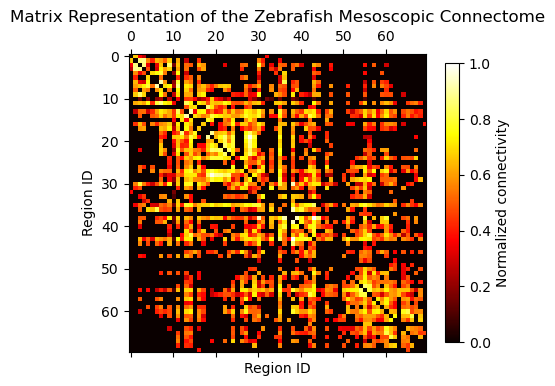

In [7]:
# Get SC data from Google Drive URL
url = 'https://drive.google.com/uc?id=1g-M_IECw0OYQOCDpxcTL7kUqo2G2VwPy'

# Output file name
filename = 'zebrafish_SC.npy'

# Download the file
gdown.download(url, filename, quiet=False)

# Load the adjacency matrix
adjacency_matrix = np.load(filename, allow_pickle=True)

# Print the shape to confirm loading
print("Adjacency matrix shape:", adjacency_matrix.shape)

# Plot the connectivity (adjacency) matrix
plt.figure(figsize=(8,8))
plt.matshow(adjacency_matrix, cmap='hot')
plt.title('Matrix Representation of the Zebrafish Mesoscopic Connectome')
plt.colorbar(label='Normalized connectivity', shrink=0.75)
plt.xlabel('Region ID')
plt.ylabel('Region ID')
plt.show()


Visualize the structural connectome using a spring layout, with node size corresponding to degree and edge width corresponding to edge weight.

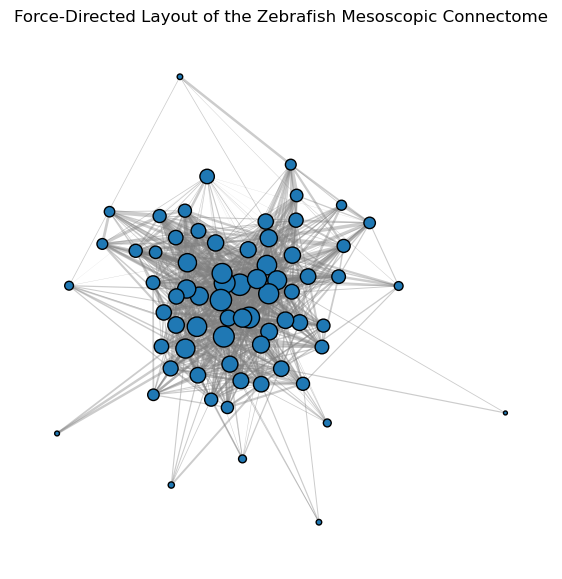

In [8]:
# Create the graph
G = nx.from_numpy_array(adjacency_matrix, create_using=nx.Graph)

# Plot the graph with force-directed layout
# Define node size using node degree
node_size_from_degree = np.array([d for n,d in G.degree()])
# Define edge width using edge weight
edge_width_from_weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
plt.figure(figsize=(7,7))
pos = nx.spring_layout(G, k=None)  # Smaller k value for more repulsion
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size = 4*node_size_from_degree,
                       edgecolors='black', linewidths=1)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='grey',
                       width = 4*edge_width_from_weights**2)
plt.title('Force-Directed Layout of the Zebrafish Mesoscopic Connectome')
plt.axis('off')
plt.show()

Compute some basic topological features.

In [9]:
# Count nodes and edges, measure density
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

# Calculate number of connected components
num_connected_components = nx.number_connected_components(G)

# Calculate the global clustering, i.e., transitivity
transitivity = nx.transitivity(G)

# Calculate the average shortest path length (considering if the graph is connected)
try:
    avg_shortest_path_length = nx.average_shortest_path_length(G, weight='weight')
except nx.NetworkXError:  # If the graph is not connected
    avg_shortest_path_length = float('inf')  # or some other indication that it's not computable

# Calculate modularity using the greedy method
communities = community.greedy_modularity_communities(G)
modularity = community.modularity(G, communities)

# Count the number of communities
num_communities = len(communities)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density:.3f}")
print(f"Number of connected components: {num_connected_components}")
print(f"Global clustering coefficient: {transitivity:.3f}")
print(f"Average shortest path length: {avg_shortest_path_length:.3f}")
print(f"Modularity (Greedy method): {modularity:.3f}")
print(f"Number of communities: {num_communities}")

Number of nodes: 70
Number of edges: 1023
Density: 0.424
Number of connected components: 1
Global clustering coefficient: 0.635
Average shortest path length: 0.624
Modularity (Greedy method): 0.145
Number of communities: 3


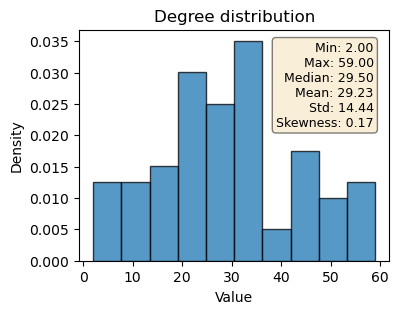

Shapiro-Wilk Test: Statistics=0.976, p-value=0.191
Normally distributed (Shapiro-Wilk) at significance level 0.001


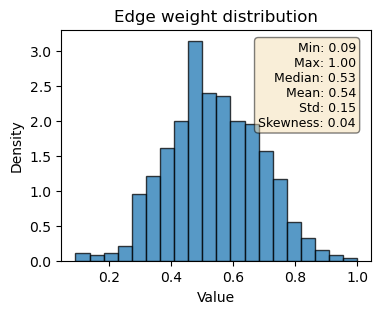

Shapiro-Wilk Test: Statistics=0.997, p-value=0.102
Normally distributed (Shapiro-Wilk) at significance level 0.001


In [10]:
from scipy.stats import skew, shapiro

def plot_histogram_with_stats(sequence, bins=20, title = 'Distribution'):
    # Calculate statistics
    min_val = np.min(sequence)
    max_val = np.max(sequence)
    median_val = np.median(sequence)
    mean_val = np.mean(sequence)
    std_val = np.std(sequence)
    skewness_val = skew(sequence)

    # Plot the normalized distribution as a density plot
    plt.figure(figsize=(4, 3))
    plt.hist(sequence, bins=bins, edgecolor='black', alpha=0.75, density=True)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Add statistics to the plot
    textstr = '\n'.join((
        f'Min: {min_val:.2f}',
        f'Max: {max_val:.2f}',
        f'Median: {median_val:.2f}',
        f'Mean: {mean_val:.2f}',
        f'Std: {std_val:.2f}',
        f'Skewness: {skewness_val:.2f}'
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right', bbox=props)

    plt.show()

# Calculate degree sequence
degree_sequence = [degree for node, degree in G.degree()]

# Plot degree distribution
plot_histogram_with_stats(degree_sequence, bins=10, title = 'Degree distribution')

# Shapiro-Wilk Test for degrees
alpha = 0.001  # Significance level
stat_shapiro, p_value_shapiro = shapiro(degree_sequence)
print(f'Shapiro-Wilk Test: Statistics={stat_shapiro:.3f}, p-value={p_value_shapiro:.3f}')
if p_value_shapiro > alpha:
    print(f'Normally distributed (Shapiro-Wilk) at significance level {alpha}')
else:
    print(f'Non-normally distributed (Shapiro-Wilk) at significance level {alpha}')


# Extract weights
weights = [G[u][v]['weight'] for u,v in G.edges()]

# Plot weight distribution
plot_histogram_with_stats(weights, bins=20, title = 'Edge weight distribution')

# Shapiro-Wilk Test for weight
alpha = 0.001  # Significance level
stat_shapiro, p_value_shapiro = shapiro(weights)
print(f'Shapiro-Wilk Test: Statistics={stat_shapiro:.3f}, p-value={p_value_shapiro:.3f}')
if p_value_shapiro > alpha:
    print(f'Normally distributed (Shapiro-Wilk) at significance level {alpha}')
else:
    print(f'Non-normally distributed (Shapiro-Wilk) at significance level {alpha}')

### **1.2 Morphological data**

Download the morphological data to locate the nodes of the connectome directly in the zebrafish brain.

Downloading...
From: https://drive.google.com/uc?id=1ITekq9dTTFZIF2AEp4S0tjISi3kA5b3W
To: /Users/patrickdesrosiers/GitHub/Graph-and-dynamical-systems-approaches-to-whole-brain-neuronal-networks/zebrafish_top_projection.npy
100%|████████████████████████████████████████| 582k/582k [00:00<00:00, 5.64MB/s]
Downloading...
From: https://drive.google.com/uc?id=14bMIQiePkdfvuF6w0Z8wensU8FsGQdEO
To: /Users/patrickdesrosiers/GitHub/Graph-and-dynamical-systems-approaches-to-whole-brain-neuronal-networks/zebrafish_side_projection.npy
100%|████████████████████████████████████████| 350k/350k [00:00<00:00, 3.21MB/s]


<Figure size 1200x700 with 0 Axes>

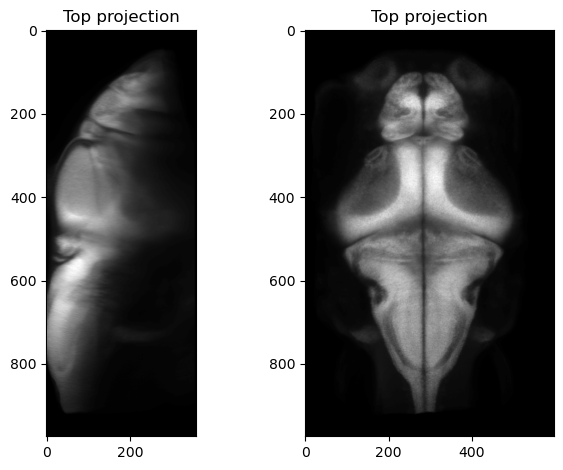

In [11]:
# Plot the graph with morphological information

# Download and load top projection of the zebrafish brain
gdown.download('https://drive.google.com/uc?id=1ITekq9dTTFZIF2AEp4S0tjISi3kA5b3W',
               'zebrafish_top_projection.npy', quiet=False)
top_projection = np.load('zebrafish_top_projection.npy')

# Download and load side projection of the zebrafish brain
gdown.download('https://drive.google.com/uc?id=14bMIQiePkdfvuF6w0Z8wensU8FsGQdEO',
               'zebrafish_side_projection.npy', quiet=False)
side_projection = np.load('zebrafish_side_projection.npy')
side_projection = ndimage.rotate(side_projection, 90)
side_projection = np.flipud(side_projection)  # Flip the image on the x-axis

# Plot morphological information
plt.figure(figsize=(12,7))
fig, axs = plt.subplots(1, 2)  # Create two subplots
axs[0].imshow(side_projection, cmap='gray')  # Display the second image
axs[0].set_title('Top projection')
axs[1].imshow(top_projection, cmap='gray')  # Display the first image
axs[1].set_title('Top projection')
# Adjust the spacing between subplots
plt.tight_layout()
plt.show()  # Show the plot


Get the relative $(x,y,z)$ of the centroid of each region. The positions are measured as number of pixels in the morphological images. The length of each pixel is about 1 micrometer.

In [12]:
# Get xy positions of nodes
# Download and load file with node positions
gdown.download('https://drive.google.com/uc?id=1yx_2GDPo9bVpVlN9JuTM282Om9k-ZHaX',
               'zebrafish_region_centroids.npy', quiet=False)
xyz = np.load('zebrafish_region_centroids.npy')

# Create dictionaries for xy and xz positions
xy = xyz[:, 0:2]
xy_dic = {i: xy[i,:] for i in range(70)}
zy = xyz[:, (2,1)]
zy_dic = {i: zy[i,:] for i in range(70)}
print(zy_dic)

Downloading...
From: https://drive.google.com/uc?id=1yx_2GDPo9bVpVlN9JuTM282Om9k-ZHaX
To: /Users/patrickdesrosiers/GitHub/Graph-and-dynamical-systems-approaches-to-whole-brain-neuronal-networks/zebrafish_region_centroids.npy
100%|██████████████████████████████████████| 3.49k/3.49k [00:00<00:00, 8.99MB/s]

{0: array([236.99374638, 106.93206841]), 1: array([204.02004319, 130.33886873]), 2: array([242.7221992 , 171.25674828]), 3: array([165.46350597, 194.46654106]), 4: array([105.74570106, 228.78869817]), 5: array([ 88.54086894, 238.99497063]), 6: array([118.19573096, 247.12261363]), 7: array([205.53071339, 246.9421667 ]), 8: array([174.14504091, 247.80773647]), 9: array([258.96660443, 248.47565653]), 10: array([270.07106996, 267.94058822]), 11: array([207.22321154, 270.5068423 ]), 12: array([ 43.42995267, 316.54547824]), 13: array([176.66981929, 310.09029392]), 14: array([138.78688576, 318.7645298 ]), 15: array([ 99.65945965, 326.09470093]), 16: array([225.16912132, 353.55281529]), 17: array([291.85414391, 361.26819044]), 18: array([ 85.72908746, 371.74580295]), 19: array([ 98.28986482, 367.74166843]), 20: array([ 95.37959358, 374.47218306]), 21: array([104.55481143, 380.05323745]), 22: array([ 97.71614015, 387.50264029]), 23: array([100.69063049, 394.98413927]), 24: array([145.67970774, 

In [13]:
# Get region names from Google Drive URL
url = 'https://drive.google.com/uc?id=12ORUByq36bJhJJFpTNqyEbzHAdmKRoCD'

# Output file name
filename = 'zebrafish_region_names.npy'

# Download the file
gdown.download(url, filename, quiet=False)

# Load region names
region_names = np.load(filename, allow_pickle=True)

# Print region ID and name
print('\n')
for id in range(len(region_names)):
  print(str(id) + ':' + region_names[id])

Downloading...
From: https://drive.google.com/uc?id=12ORUByq36bJhJJFpTNqyEbzHAdmKRoCD
To: /Users/patrickdesrosiers/GitHub/Graph-and-dynamical-systems-approaches-to-whole-brain-neuronal-networks/zebrafish_region_names.npy
100%|██████████████████████████████████████| 18.6k/18.6k [00:00<00:00, 1.36MB/s]



0:olfactory_epithelium
1:olfactory_bulb
2:ventral_telencephalon_(subpallium)
3:dorsal_telencephalon_(pallium)
4:dorsal_habenula
5:epiphysis
6:ventral_habenula
7:ventral_entopeduncular_nucleus
8:eminentia_thalami_(remaining)
9:preoptic_region
10:retina
11:ventral_thalamus__alar_part
12:torus_longitudinalis
13:dorsal_thalamus_proper
14:pretectum__alar_part
15:stratum_opticum
16:posterior_tuberculum_(basal_part_of_prethalamus_and_thalamus)
17:rostral_hypothalamus
18:stratum_marginale
19:stratum_fibrosum_et_griseum_superficiale
20:sfgs__sgc
21:stratum_griseum_centrale
22:sac__spv
23:stratum_album_centrale
24:medial_tegmentum_(remaining)
25:diffuse_nucleus_of_the_inferior_lobe
26:nucleus_of_the_medial_longitudinal_fascicle_(pretectum_basal_part)
27:lateral_tegmentum
28:periventricular_layer
29:torus_semicircularis
30:intermediate_hypothalamus_(remaining)
31:oculomotor_nucleus
32:trigeminal_ganglion
33:trochlear_motor_nucleus
34:pituitary
35:nucleus_isthmi
36:interpeduncular_nucleus
37:ant

/var/folders/jz/cr2pd13j7g7fv41cf5q_t7w00000gn/T/ipykernel_7643/3303016793.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 2000x1000 with 0 Axes>

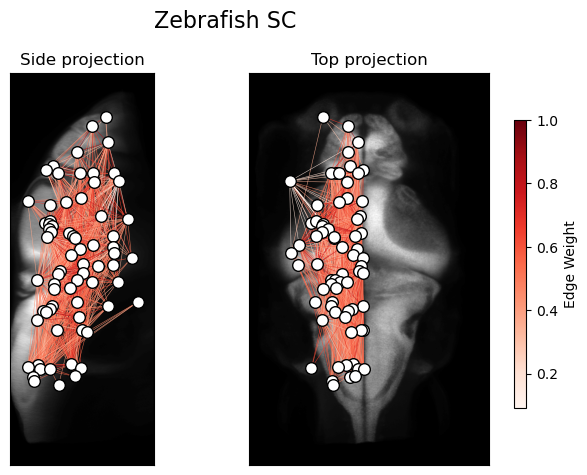

In [14]:
# Define colormap for edges
cmap = cm.ScalarMappable(cmap='Reds')

# Plot morphological information and connectome information
plt.figure(figsize=(20, 10))
fig, axs = plt.subplots(1, 2)  # Create two subplots

# Display the second image
axs[0].imshow(side_projection, cmap='gray')  # Display the second image
nx.draw_networkx_nodes(G, zy_dic, ax=axs[0], node_color='white',
                       node_size=70, edgecolors='black', linewidths=1)
nx.draw_networkx_edges(G, zy_dic, ax=axs[0], alpha=0.8,
                       edge_color=cmap.to_rgba(weights), width=0.4)
axs[0].set_title('Side projection')

# Display the first image and the network on the same subplot
axs[1].imshow(top_projection, cmap='gray')  # Display the first image
nx.draw_networkx_nodes(G, xy_dic, ax=axs[1], node_color='white',
                       node_size=70, edgecolors='black', linewidths=1)
nx.draw_networkx_edges(G, xy_dic, ax=axs[1], alpha=0.8,
                       edge_color=cmap.to_rgba(weights), width=0.4)
axs[1].set_title('Top projection')

# Add a global title
plt.suptitle('Zebrafish SC', fontsize=16)

# Add vertical color bar to the left
fig.subplots_adjust(left=0.1, right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.6])  # [left, bottom, width, height]
cbar = plt.colorbar(cmap, cax=cbar_ax, orientation='vertical')
cbar.set_label('Edge Weight')

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()  # Show the plot

## <font color="blue"> **2. Functional data** </font>

Functional connectomes are comprehensive maps that illustrate the functional connections between different elements within the brain, whether they are neurons, groups of neurons, or large brain regions. These maps detail how different parts of the brain interact and coordinate activity, providing a dynamic framework for understanding brain function and communication.




### **2.1 Functional dataset from Paul De Koninck's Lab**



#### **2.1.1 Experimental Setup**

Resonant-scanning two-photon microscopy was used to capture brain-wide neuronal activity at single-cell resolution in transgenic zebrafish larvae (Tg(elavl3:H2B-GCaMP6s)), with **22 larvae** aged 5-7 days post-fertilization (dpf). Larvae were immobilized in low-melting point agarose, and tail movements were tracked by a high-speed infrared camera. During the experiment, larvae were exposed to **static whole-field illumination for 10 minutes**, followed by **abrupt dark transitions (dark flashes) over 3 minutes**.

A piezo-driven objective rapidly acquired nuclear signals across 21 imaging planes, covering the entire larval brain except the most ventral neuronal populations. Imaging volumes were registered to the mapZebrain brain atlas using ANTs registration, transforming the coordinates of all neuronal nuclei into the atlas coordinate system. Neurons were assigned to one of **70 anatomical brain regions**. Five regions were excluded due to inconsistent sampling or absence of labeled nuclei. In total, the activity of approximately 54,464 neurons across 65 brain regions was recorded, representing roughly half of the neuronal population at this developmental stage.

#### **2.1.2 Dataset: Activity of 70 Brain Regions in 22 Larval Zebrafish**

The time series data of all neurons were first converted to $\Delta F / F_0$ and then averaged by region. As a result, regional signals might not have a baseline of 0 because the averaging reflects a non-zero mean activity.

Notes:
1. **Visual Stimulation**: Visual stimulation begins at approximately $t=660$ (time steps). For spontaneous activity, consider using data before $t=600$. To analyze correlations reflecting the stimulation, use data after t=600.
2. **Region Inclusion**: Although data for all 70 regions are kept, several larvae do not sample all regions. To reduce the arrays to 65 regions, use `excluded_regions.npy` with `np.delete(timeseries, excluded_regions, axis=0)`.
3. **Under-sampling**: Even after excluding the 5 regions, some larvae may still have under-sampled regions. The exclusion criterion was to retain only the regions imaged in more than 50% of the larvae. Thus, when generating correlation matrices or other statistical measures across all larvae, NaNs might appear due to rows of zeros. This issue can be circumvented by applying `np.nanmean` across the matrices to obtain an average functional connectivity (FC) matrix, where each pixel has a different denominator based on the number of samples.
4. **Filtering**: Applying a Gaussian filter (e.g., `from scipy.ndimage import gaussian_filter1d`, with `sigma=2`) on the time series is recommended. This approach yields more refined correlations, suggesting that low-frequency content might be more crucial for detecting functional interactions.

Below, we download the time series for Fish 6, slightly smooth them with a Gaussian filter, and visualize them using a heatmap and a ridgeline plot.

In [16]:
# # Step 1: Mount Google Drive (optional, if you want to save the file locally)
# drive.mount('/content/drive')

# # Step 2: Download the file using wget
# !wget https://github.com/pdesrosiers/public_data/raw/main/zebrafish_functional_data/timeseries_regions_fish6.npy -O /content/timeseries_regions_fish6.npy

# # Step 3: Load the .npy file using numpy
# file_path = '/content/timeseries_regions_fish6.npy'
# timeseries6  = np.load(file_path)

# # Verify the data by printing its shape
# print(timeseries6.shape)

# # Step 4: Apply Gaussian smoothing along the time axis (axis=1)
# sigma = 2  # Adjust sigma as needed
# smoothed_timeseries6 = gaussian_filter1d(timeseries6, sigma=sigma, axis=1)

import os
import numpy as np
from scipy.ndimage import gaussian_filter1d
import urllib.request

# Step 1: Define local file path
local_dir = "data"
os.makedirs(local_dir, exist_ok=True)
file_path = os.path.join(local_dir, "timeseries_regions_fish6.npy")

# Step 2: Download file if not already present
url = "https://github.com/pdesrosiers/public_data/raw/main/zebrafish_functional_data/timeseries_regions_fish6.npy"

if not os.path.exists(file_path):
    print("Downloading data...")
    urllib.request.urlretrieve(url, file_path)
    print("Download complete.")
else:
    print("File already exists. Skipping download.")

# Step 3: Load the .npy file
timeseries6 = np.load(file_path)
print("Data shape:", timeseries6.shape)

# Step 4: Apply Gaussian smoothing along the time axis (axis=1)
sigma = 2  # You can adjust this parameter
smoothed_timeseries6 = gaussian_filter1d(timeseries6, sigma=sigma, axis=1)


Download complete.
Data shape: (70, 892)


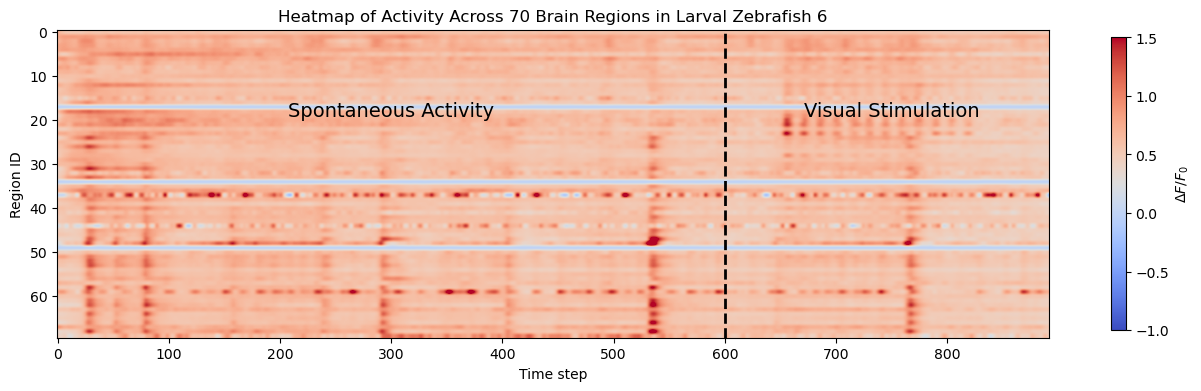

In [17]:
# Plot the time series as a heatmap
plt.figure(figsize=(16,4))
# Plot matrix as an image
plt.imshow(smoothed_timeseries6, cmap='coolwarm', vmin=-1, vmax=1.5, aspect='auto')
# Add vertical dashed line
plt.axvline(x=600, color='k', linestyle='--', linewidth=2)
# Add text annotations
plt.text(300, 18, 'Spontaneous Activity', horizontalalignment='center', verticalalignment='center', fontsize=14)
plt.text(750, 18, 'Visual Stimulation', horizontalalignment='center', verticalalignment='center', fontsize=14)
plt.xlabel('Time step')
plt.ylabel('Region ID')
plt.colorbar(label='$\Delta F / F_0$', shrink=0.95)
plt.title('Heatmap of Activity Across 70 Brain Regions in Larval Zebrafish 6')
plt.show()

Below, we show the time series as a ridgeline plot.

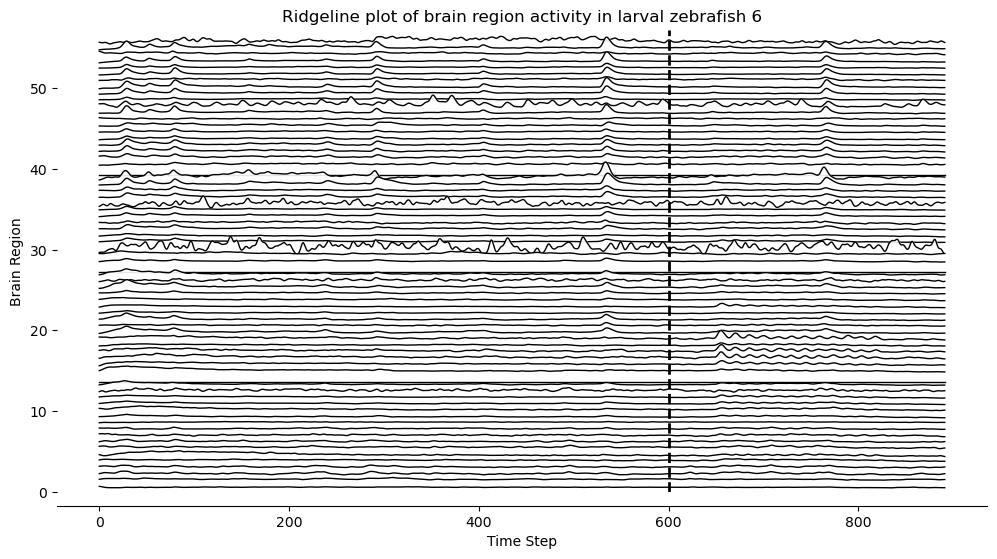

In [19]:
# Define the offset between each time series for better visualization
offset = 0.8

# Plot each time series with an offset and fill the area below each curve in reverse order
plt.figure(figsize=(12, 6))
for i in range(len(smoothed_timeseries6) - 1, -1, -1):  # Reverse order
    row = smoothed_timeseries6[i]
    plt.plot(row + i * offset, label=f'Region {i+1}', c='k', linewidth=1.0, zorder=len(smoothed_timeseries6) - i)
    plt.fill_between(np.arange(row.size), i * offset, row + i * offset,
                     alpha=0.9, color='white', zorder=len(smoothed_timeseries6) - i - 1)  # Adjust zorder

plt.title('Ridgeline plot of brain region activity in larval zebrafish 6')
plt.xlabel('Time Step')
plt.ylabel('Brain Region')

# Add a vertical dashed line at time step 600
plt.axvline(x=600, color='k', linestyle='--', linewidth=2, zorder=len(smoothed_timeseries6) + 1)

# Remove the top and right spines (box)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_position(('outward', 10))  # Adjust the position of the bottom spine

# Set y-axis limits
plt.ylim(0, (len(smoothed_timeseries6) - 1) * offset + 2)
plt.show()


### **2.2 Extraction of Functional Connectomes**

We will now separate the time series into two parts: spontaneous activity and activity under visual stimulation. This will allow us to define two functional connectomes and compare their topological properties.

/Users/patrickdesrosiers/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


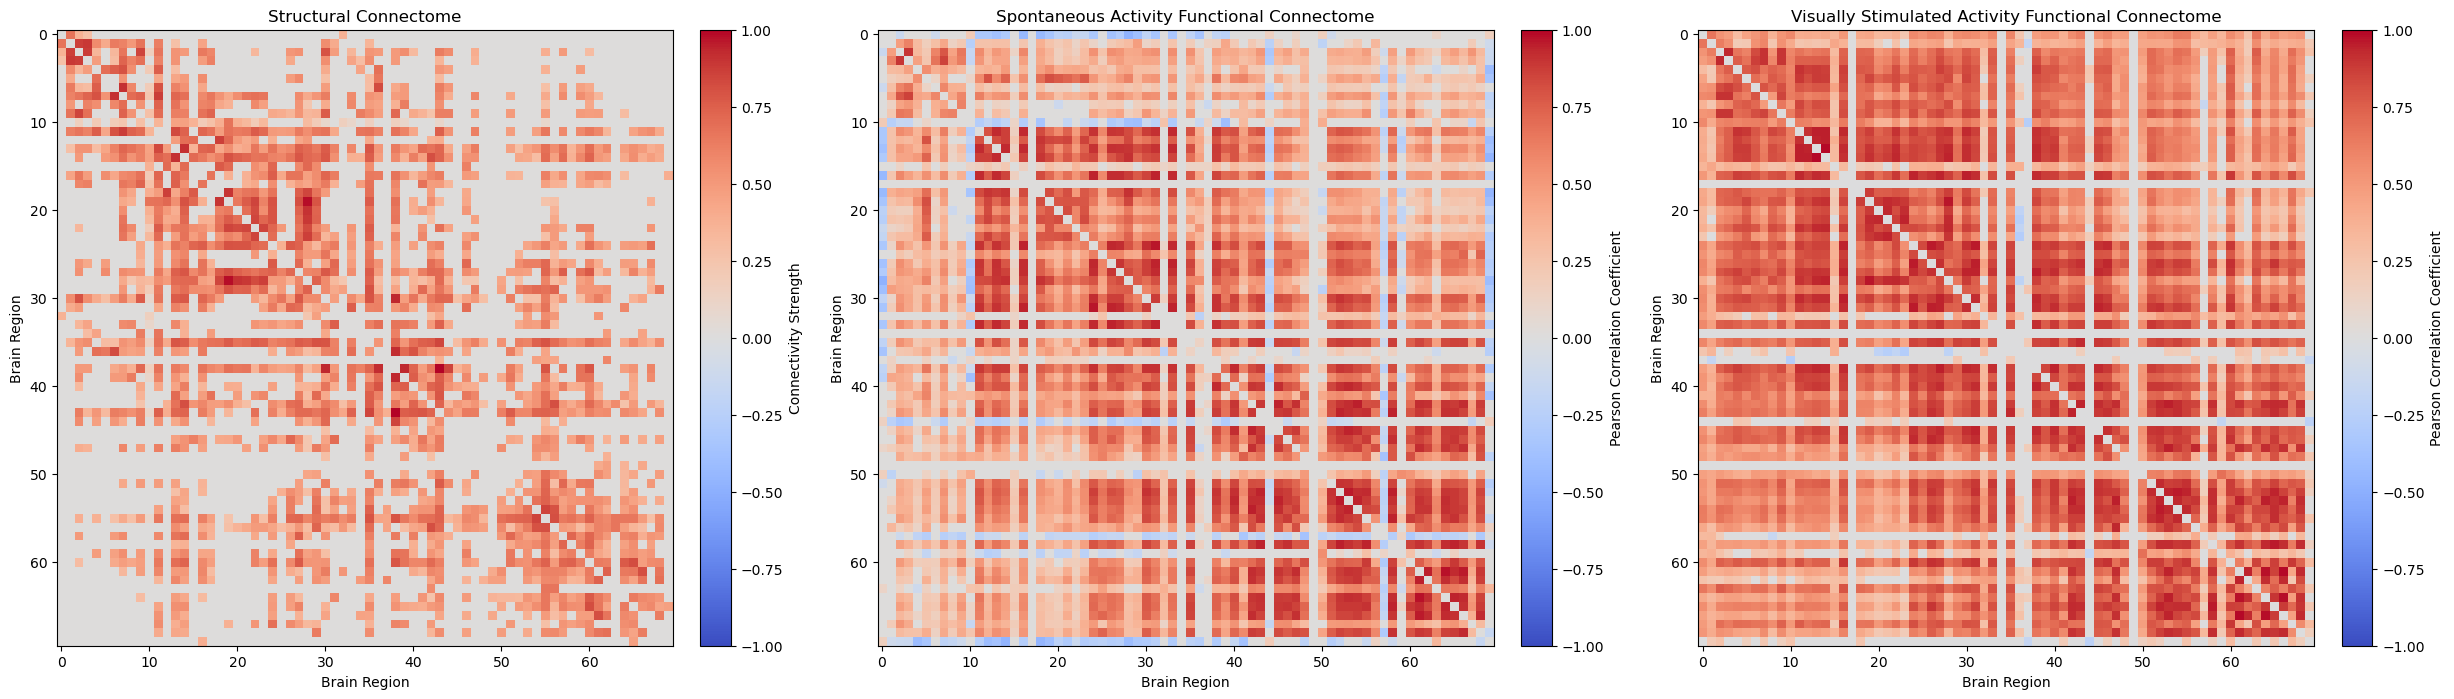

In [20]:
# Separate spontaneous and visually stimulated activity
spontaneous_activity = smoothed_timeseries6[:, 0:600]
stimulated_activity = smoothed_timeseries6[:, 600:]

# Initialize matrices for functional connectomes
num_neurons = spontaneous_activity.shape[0]
spontaneous_FC = np.zeros((num_neurons, num_neurons))
stimulated_FC = np.zeros((num_neurons, num_neurons))

# Function to compute correlation and p-value
def compute_corr_pvalue_matrix(activity):
    num_neurons = activity.shape[0]
    corr_matrix = np.zeros((num_neurons, num_neurons))
    pvalue_matrix = np.ones((num_neurons, num_neurons))

    for i in range(num_neurons):
        for j in range(i + 1, num_neurons):
            if i != j:
                corr, pvalue = stats.pearsonr(activity[i], activity[j])
                corr_matrix[i, j] = corr
                corr_matrix[j, i] = corr
                pvalue_matrix[i, j] = pvalue
                pvalue_matrix[j, i] = pvalue
    return corr_matrix, pvalue_matrix

# Compute functional connectomes and p-values
spontaneous_corr_matrix, spontaneous_pvalue_matrix = compute_corr_pvalue_matrix(spontaneous_activity)
stimulated_corr_matrix, stimulated_pvalue_matrix = compute_corr_pvalue_matrix(stimulated_activity)

# Set a p-value threshold below which functional relationships are considered significant
pvalue_threshold = 0.01

# Apply p-value threshold to filter out non-significant correlations
spontaneous_FC[spontaneous_pvalue_matrix < pvalue_threshold] = spontaneous_corr_matrix[spontaneous_pvalue_matrix < pvalue_threshold]
stimulated_FC[stimulated_pvalue_matrix < pvalue_threshold] = stimulated_corr_matrix[stimulated_pvalue_matrix < pvalue_threshold]

# Create subplots to visualize structural and functional connectomes side by side
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

# Plot the structural connectome
im0 = axes[0].imshow(adjacency_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Structural Connectome')
axes[0].set_xlabel('Brain Region')
axes[0].set_ylabel('Brain Region')

# Plot the spontaneous functional connectome
im1 = axes[1].imshow(spontaneous_FC, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Spontaneous Activity Functional Connectome')
axes[1].set_xlabel('Brain Region')
axes[1].set_ylabel('Brain Region')

# Plot the visually stimulated functional connectome
im2 = axes[2].imshow(stimulated_FC, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title('Visually Stimulated Activity Functional Connectome')
axes[2].set_xlabel('Brain Region')
axes[2].set_ylabel('Brain Region')

# Add colorbars
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label='Connectivity Strength')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label='Pearson Correlation Coefficient')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label='Pearson Correlation Coefficient')

# Show the plot
plt.show()


#### **2.2.4 Structure-Function Relationship**

We will now compare the zebrafish structural connectome at mesoscale with the two functional connectomes we extracted.

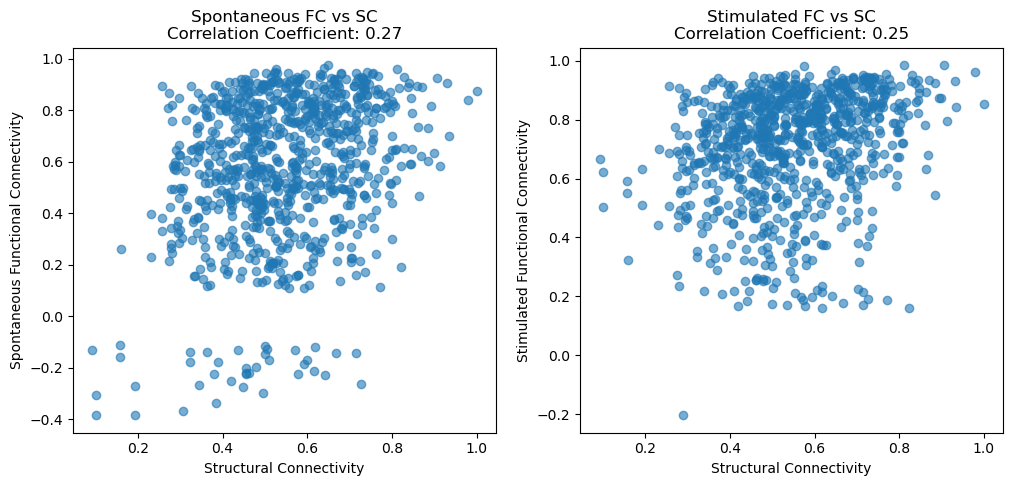

In [21]:
# Extract the upper triangle values excluding the diagonal
def get_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

sc_upper = get_upper_triangle(adjacency_matrix)
spontaneous_fc_upper = get_upper_triangle(spontaneous_FC)
stimulated_fc_upper = get_upper_triangle(stimulated_FC)

# Filter out zero values in SC
nonzero_indices = (sc_upper != 0) & (spontaneous_fc_upper != 0) & (stimulated_fc_upper != 0)
filtered_sc_upper = sc_upper[nonzero_indices]
filtered_spontaneous_fc_upper = spontaneous_fc_upper[nonzero_indices]
filtered_stimulated_fc_upper = stimulated_fc_upper[nonzero_indices]

# Compute correlation coefficients
corr_spontaneous = np.corrcoef(filtered_sc_upper, filtered_spontaneous_fc_upper)[0, 1]
corr_stimulated = np.corrcoef(filtered_sc_upper, filtered_stimulated_fc_upper)[0, 1]

# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Scatter plot for spontaneous FC vs SC
axes[0].scatter(filtered_sc_upper, filtered_spontaneous_fc_upper, alpha=0.6)
axes[0].set_xlabel('Structural Connectivity')
axes[0].set_ylabel('Spontaneous Functional Connectivity')
axes[0].set_title(f'Spontaneous FC vs SC\nCorrelation Coefficient: {corr_spontaneous:.2f}')

# Scatter plot for stimulated FC vs SC
axes[1].scatter(filtered_sc_upper, filtered_stimulated_fc_upper, alpha=0.6)
axes[1].set_xlabel('Structural Connectivity')
axes[1].set_ylabel('Stimulated Functional Connectivity')
axes[1].set_title(f'Stimulated FC vs SC\nCorrelation Coefficient: {corr_stimulated:.2f}')

# Show the plots
plt.show()

We can also compute the correlation between functional connectivity and node distance.  

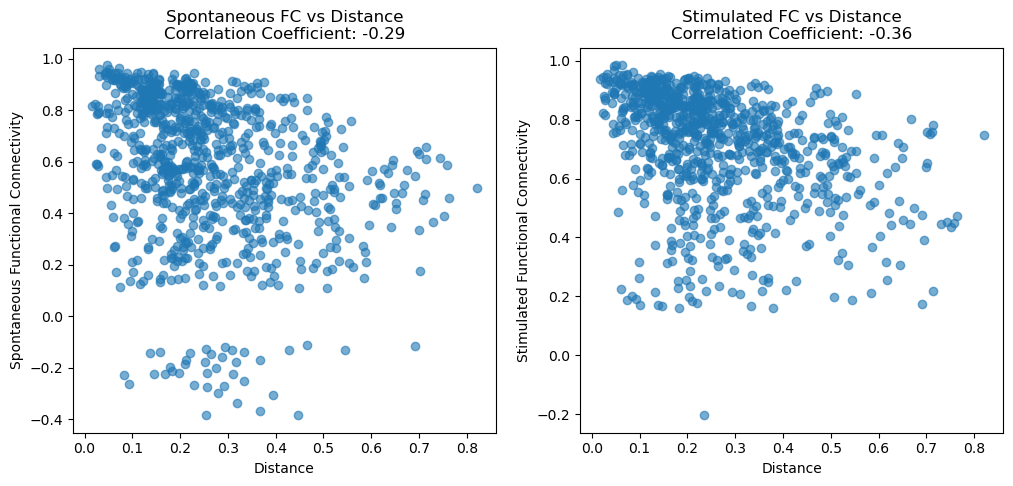

In [22]:
# Extract the node coordinates into a NumPy array
coords = xyz[0:70,:]#np.array(list(xy_dic.values()))

# Compute the distance matrix
distance_matrix = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2)

# Normalize the distance matrix to [0, 1]
distance_matrix /= distance_matrix.max()

# Get the upper triangle values in the distance matrix
distance_matrix_upper = get_upper_triangle(distance_matrix)
filtered_sdistance_matrix_upper = distance_matrix_upper[nonzero_indices]

# Compute correlation coefficients
corr_spontaneous = np.corrcoef(filtered_sdistance_matrix_upper, filtered_spontaneous_fc_upper)[0, 1]
corr_stimulated = np.corrcoef(filtered_sdistance_matrix_upper, filtered_stimulated_fc_upper)[0, 1]

# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Scatter plot for spontaneous FC vs SC
axes[0].scatter(filtered_sdistance_matrix_upper, filtered_spontaneous_fc_upper, alpha=0.6)
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Spontaneous Functional Connectivity')
axes[0].set_title(f'Spontaneous FC vs Distance\nCorrelation Coefficient: {corr_spontaneous:.2f}')

# Scatter plot for stimulated FC vs SC
axes[1].scatter(filtered_sdistance_matrix_upper, filtered_stimulated_fc_upper, alpha=0.6)
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Stimulated Functional Connectivity')
axes[1].set_title(f'Stimulated FC vs Distance\nCorrelation Coefficient: {corr_stimulated:.2f}')

# Show the plots
plt.show()



### **2.3 Exercise**

The previous correlations are quite low, but they only concern one zebrafish. Use the following dataset to compute the spontaneous and stimulated FCs for each of the 22 fish, and then average these FCs and compare them to the SC. Does the coupling between the FCs and SC get stronger?

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Step 1: Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define a function to download and load each .npy file
def load_and_smooth_timeseries(file_num, sigma=2):
    file_url = f'https://github.com/pdesrosiers/public_data/raw/main/zebrafish_functional_data/timeseries_regions_fish{file_num}.npy'
    file_path = f'/content/timeseries_regions_fish{file_num}.npy'

    # Download the file
    !wget {file_url} -O {file_path}

    # Load the file
    timeseries = np.load(file_path)

    # Apply Gaussian smoothing
    smoothed_timeseries = gaussian_filter1d(timeseries, sigma=sigma, axis=1)

    return smoothed_timeseries

# Step 3: Load and smooth all timeseries data from fish 1 to 22
all_smoothed_timeseries = []
for i in range(1, 23):
    smoothed_timeseries = load_and_smooth_timeseries(i, sigma=2)
    all_smoothed_timeseries.append(smoothed_timeseries)
    print(f'\nLoaded and smoothed timeseries for fish {i} with shape {smoothed_timeseries.shape}\n')


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Define the function to split the timeseries matrix
def split_timeseries(matrix, split_time_step):
    spontaneous_activity = matrix[:, :split_time_step]
    stimulated_activity = matrix[:, split_time_step:]
    return spontaneous_activity, stimulated_activity

# Define the function to split all timeseries in a list
def split_all_timeseries(matrix_list, split_time_step):
    all_spontaneous_activities = []
    all_stimulated_activities = []

    for matrix in matrix_list:
        spontaneous_activity, stimulated_activity = split_timeseries(matrix, split_time_step)
        all_spontaneous_activities.append(spontaneous_activity)
        all_stimulated_activities.append(stimulated_activity)

    return all_spontaneous_activities, all_stimulated_activities

# Apply the split function to all matrices
split_time_step = 600
all_spontaneous_activities, all_stimulated_activities = split_all_timeseries(all_smoothed_timeseries, split_time_step)

# Compute functional connectomes from a list of time series
def compute_connectomes(activity_list):
    connectomes = []
    for activity in activity_list:
        connectome = np.nan_to_num(np.corrcoef(activity), nan=0.0) # replace NaNs for 0
        connectomes.append(connectome)
    return connectomes

# Compute connectomes for spontaneous and stimulated activities
spontaneous_connectomes = compute_connectomes(all_spontaneous_activities)
stimulated_connectomes = compute_connectomes(all_stimulated_activities)

# Compute the mean functional connectome for each list of connectomes
mean_spontaneous_FC = np.mean(spontaneous_connectomes, axis=0)
mean_stimulated_FC = np.mean(stimulated_connectomes, axis=0)

# Print the shapes of the mean connectomes to verify
print(f'Mean spontaneous connectome shape: {mean_spontaneous_FC.shape}')
print(f'Mean stimulated connectome shape: {mean_stimulated_FC.shape}')


In [ ]:
# Create subplots to visualize structural and functional connectomes side by side
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

# Plot the structural connectome
im0 = axes[0].imshow(adjacency_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Structural Connectome')
axes[0].set_xlabel('Brain Region')
axes[0].set_ylabel('Brain Region')

# Plot the spontaneous functional connectome
im1 = axes[1].imshow(mean_spontaneous_FC, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Spontaneous Activity Functional Connectome')
axes[1].set_xlabel('Brain Region')
axes[1].set_ylabel('Brain Region')

# Plot the visually stimulated functional connectome
im2 = axes[2].imshow(mean_stimulated_FC, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title('Visually Stimulated Activity Functional Connectome')
axes[2].set_xlabel('Brain Region')
axes[2].set_ylabel('Brain Region')

# Add colorbars
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label='Connectivity Strength')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label='Pearson Correlation Coefficient')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label='Pearson Correlation Coefficient')

# Show the plot
plt.show()

In [ ]:
# Extract the upper triangle values excluding the diagonal
def get_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

sc_upper = get_upper_triangle(adjacency_matrix)
spontaneous_fc_upper = get_upper_triangle(mean_spontaneous_FC)
stimulated_fc_upper = get_upper_triangle(mean_stimulated_FC)

# Filter out zero values in SC
nonzero_indices = (sc_upper != 0) & (spontaneous_fc_upper != 0) & (stimulated_fc_upper != 0)
filtered_sc_upper = sc_upper[nonzero_indices]
filtered_spontaneous_fc_upper = spontaneous_fc_upper[nonzero_indices]
filtered_stimulated_fc_upper = stimulated_fc_upper[nonzero_indices]

# Compute correlation coefficients
corr_spontaneous = np.corrcoef(filtered_sc_upper, filtered_spontaneous_fc_upper)[0, 1]
corr_stimulated = np.corrcoef(filtered_sc_upper, filtered_stimulated_fc_upper)[0, 1]

# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Scatter plot for spontaneous FC vs SC
axes[0].scatter(filtered_sc_upper, filtered_spontaneous_fc_upper, alpha=0.6)
axes[0].set_xlabel('Structural Connectivity')
axes[0].set_ylabel('Mean Spontaneous FC')
axes[0].set_title(f'Spontaneous FC vs SC\nCorrelation Coefficient: {corr_spontaneous:.2f}')

# Scatter plot for stimulated FC vs SC
axes[1].scatter(filtered_sc_upper, filtered_stimulated_fc_upper, alpha=0.6)
axes[1].set_xlabel('Structural Connectivity')
axes[1].set_ylabel('Mean Stimulated FC')
axes[1].set_title(f'Stimulated FC vs SC\nCorrelation Coefficient: {corr_stimulated:.2f}')

# Show the plots
plt.show()

In [ ]:
# Extract the node coordinates into a NumPy array
coords = xyz[0:70,:]#np.array(list(xy_dic.values()))

# Compute the distance matrix
distance_matrix = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2)

# Normalize the distance matrix to [0, 1]
distance_matrix /= distance_matrix.max()

# Get the upper triangle values in the distance matrix
distance_matrix_upper = get_upper_triangle(distance_matrix)
filtered_sdistance_matrix_upper = distance_matrix_upper[nonzero_indices]

# Compute correlation coefficients
corr_spontaneous = np.corrcoef(filtered_sdistance_matrix_upper, filtered_spontaneous_fc_upper)[0, 1]
corr_stimulated = np.corrcoef(filtered_sdistance_matrix_upper, filtered_stimulated_fc_upper)[0, 1]

# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Scatter plot for spontaneous FC vs SC
axes[0].scatter(filtered_sdistance_matrix_upper, filtered_spontaneous_fc_upper, alpha=0.6)
axes[0].set_xlabel('Normalized Distance')
axes[0].set_ylabel('Spontaneous FC')
axes[0].set_title(f'Spontaneous FC vs Distance\nCorrelation Coefficient: {corr_spontaneous:.2f}')

# Scatter plot for stimulated FC vs SC
axes[1].scatter(filtered_sdistance_matrix_upper, filtered_stimulated_fc_upper, alpha=0.6)
axes[1].set_xlabel('Normalized Distance')
axes[1].set_ylabel('Stimulated FC')
axes[1].set_title(f'Stimulated FC vs Distance\nCorrelation Coefficient: {corr_stimulated:.2f}')

# Show the plots
plt.show()